# LAA Assignment 5

submission by: Utpalraj Kemprai (MDS202352)

#### Loading the libraries and dataset

In [1]:
# importing necessary libraries
# python version 3.12.2
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
# loading the dataset
data = mnist.load_data()

#### Splitting the train and test data

In [3]:
# sorting into train and test data
train, test = data
X_train, y_train = train
X_test, y_test = test

#### Function to unwrap images from matrix to vectors

In [4]:
# function to unwrap 28x28 image matrices in the train and test data
def unwrap(x):
    return np.reshape(x,newshape=(len(x),28*28))

In [5]:
# unwrapping the image matrices
X_train = unwrap(X_train)
X_test = unwrap(X_test)

In [6]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [7]:
y_train.shape, y_test.shape

((60000,), (10000,))

#### For each digit i form a matrix whose columns are images of that digit.

In [200]:
# dictionary to store training images for each digit
D = {}
np.random.RandomState(seed=42)

RandomState(MT19937) at 0x2018FFAFD40

In [201]:
# storing the image matrices corresponding to each digit in D
# we choose 2500 images for each digit at random from train data
for i in range(10):
    D[i] = X_train[y_train == i][np.random.choice(range(len(y_train[y_train==i])),2500,replace=False)]
    D[i] = np.transpose(D[i])

#### Function to calculate first 4 principal components

In [202]:
def first4_left_vectors(M):
    U, S, Vt = np.linalg.svd(M,full_matrices=True,compute_uv=True)
    U = np.transpose(U)
    return U[0].T,U[1].T,U[2].T,U[3].T

#### Image from training data and left singular vectors of D[i] for i = 0, 1, $\cdots$,9

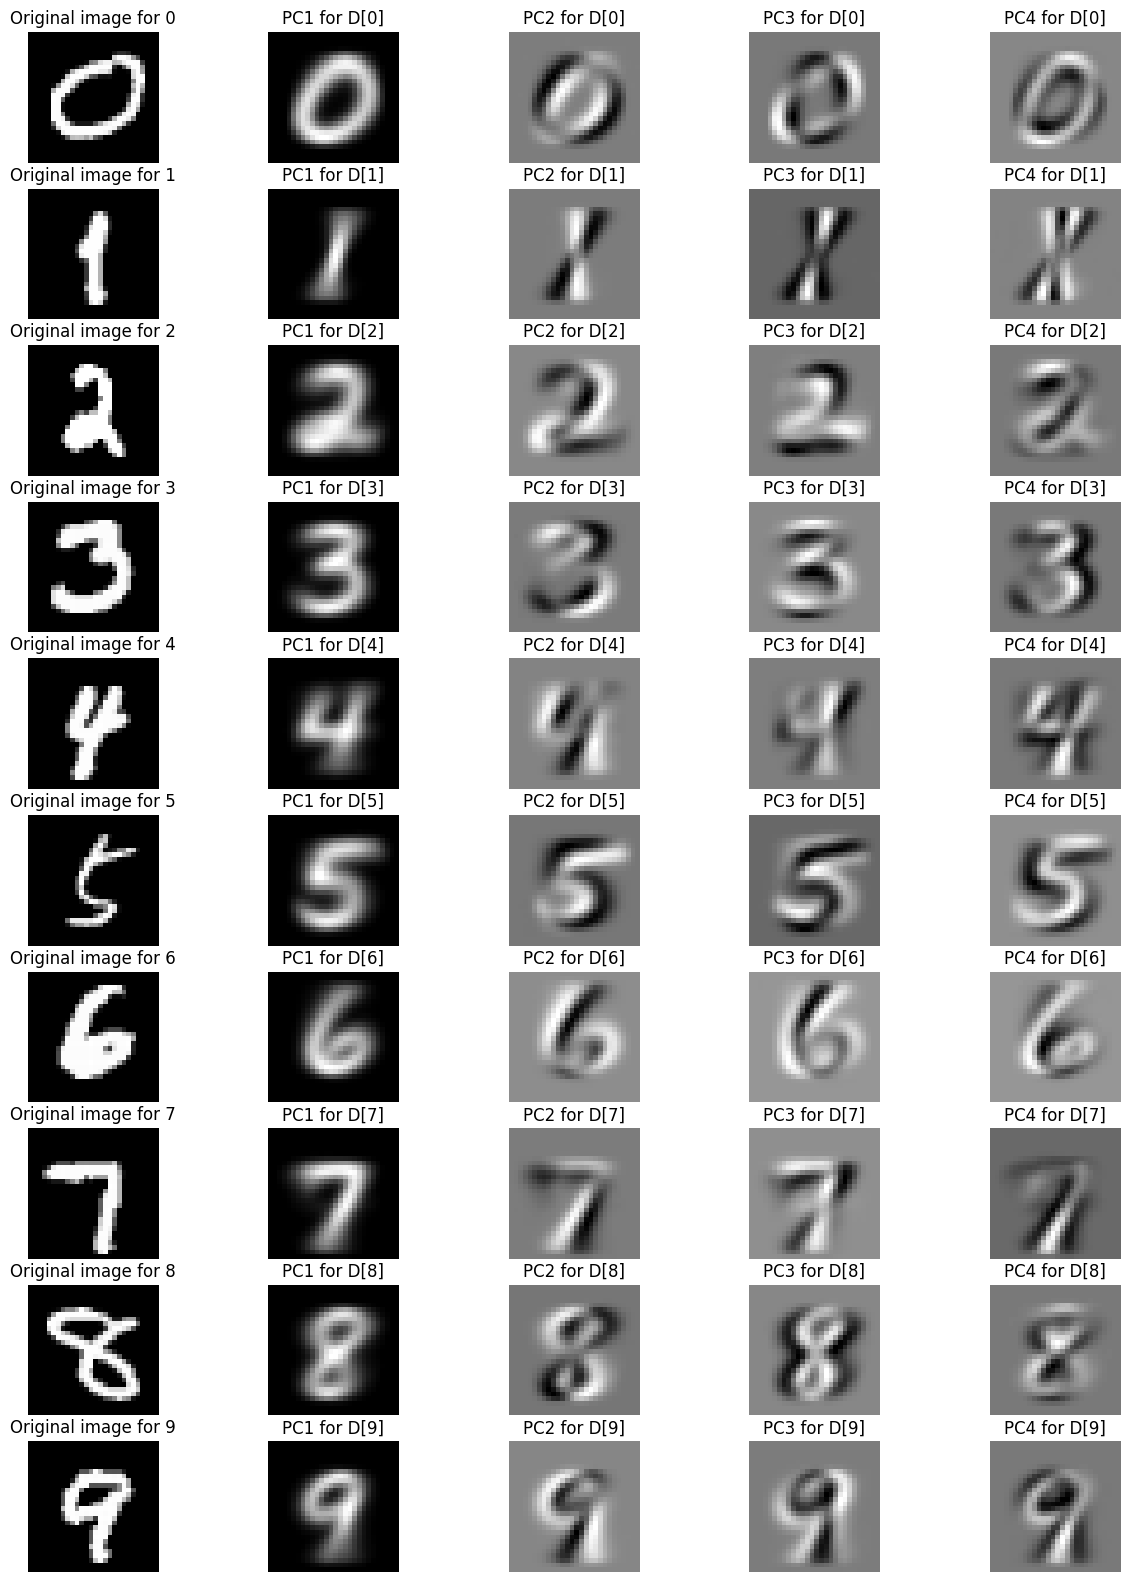

In [203]:
fig ,ax = plt.subplots(10,5)
fig.set_figwidth(15)
fig.set_figheight(20)
for i in range(10):
    d = first4_left_vectors(D[i])
    for j in range(5):
        if j > 0:
            ax[i,j].imshow(d[j-1].reshape(28,28),cmap=plt.get_cmap('gray_r'))
            ax[i, j].axis('off')
            ax[i,j].set_title("PC" + str(j) + " for D[" + str(i) +"]")
        else:
            ax[i,j].imshow(D[i].T[0].reshape(28,28),cmap = plt.get_cmap('gray'))
            ax[i,j].axis('off')
            ax[i,j].set_title("Original image for "+ str(i))


#### Function for SVD of image matrices

In [204]:
def svd(D):
    U, S, Vt = np.linalg.svd(D,full_matrices=True,compute_uv=True)
    # low_rank = U[:, :k] , np.diag(S[:k]) , Vt[:k, :]
    low_rank = U, S, Vt
    return low_rank   

In [205]:
svd_images = [svd(D[i]) for i in range(10)]

### Digit classifier
We define the following digit classifier :
 $\rho(z) = \underset{0 \leq n \leq 9}{\operatorname{argmin}}\{\min\limits_x{ \|\hat{D}(n) x - z\|_{2}}\}$

where $\hat{D}(n)$ is a low rank approximation of $D(n)$

The reason behind our choice of the expression is that, for our choice of expression is that if,
$\hat{D}(n)$ has rank $r$, then 

$\|\hat{D}(n) x - z\|^2_{2} = \sum\limits_{i=1}^{r} (\sigma_i y_i - u^{T}_i z)^2 + \sum\limits_{i=r+1}^{m} (u^{T}_i z)^2$

Where $\hat{D}(n) = U\Sigma V^T \in \rm I\!R^{m \times n}$ and $y = \Sigma V^T x $

Thus, $\min\limits_x \|\hat{D}(n) x - z\|_{2} = \sqrt{\sum\limits_{i=r+1}^{m} (u^{T}_i z)^2}$

And so, $\rho(z) = \underset{0 \leq n \leq 9}{\operatorname{argmin}} \{ \sqrt{\sum\limits_{i=r+1}^{m} (u^{T}_i z)^2} : u_i \in col(U), \hat{D}(n) = U\Sigma V^T, rank(\hat{D}(n)) = r \} $

Thus $\rho(z) = \underset{0 \leq n \leq 9}{\operatorname{argmin}} \{ {\sum\limits_{i=r+1}^{m} (u^{T}_i z)^2} : u_i \in col(U), \hat{D}(n) = U\Sigma V^T, rank(\hat{D}(n)) = r \} $, which is the expression we use for our digit classifier below.

#### Function for digit classification of image vectors

In [213]:
def digit_classifier(z):
    result = 0
    m = (np.linalg.norm((svd_images[0][0][:,15:]).T@z))
    for i in range(1,10):
        norm = (np.linalg.norm((svd_images[i][0][:,15:]).T@z))
        if norm < m:
            result = i
            m = norm
    return result

#### Performance on Test Data

In [214]:
n = len(y_test)
y_pred = [-1 for i in range(n)]

In [215]:
from tqdm import tqdm
start = time()
for i in tqdm(range(n)):
    y_pred[i] = digit_classifier(X_test[i])
end = time()
    

100%|██████████| 10000/10000 [01:16<00:00, 131.21it/s]


Average Time needed by the digit classifier for classifying a digit (sec)

In [216]:
(end - start)/len(y_pred)

0.00762206084728241

##### Accuracy of digit classifier

In [217]:
# accuracy
sum(y_pred == y_test)/len(y_test)

0.9515

##### Confusion Matrix

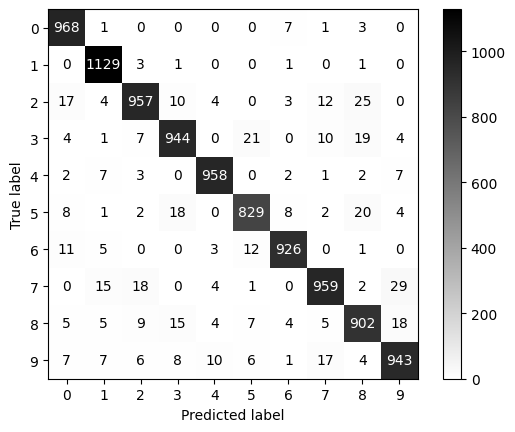

In [218]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels = list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(10)))
disp.plot(cmap = plt.get_cmap('gray_r'))
plt.show()

##### Classification Report

In [219]:
print(classification_report(y_test,y_pred,labels=list(range(10)),digits=3))

              precision    recall  f1-score   support

           0      0.947     0.988     0.967       980
           1      0.961     0.995     0.977      1135
           2      0.952     0.927     0.940      1032
           3      0.948     0.935     0.941      1010
           4      0.975     0.976     0.975       982
           5      0.946     0.929     0.938       892
           6      0.973     0.967     0.970       958
           7      0.952     0.933     0.943      1028
           8      0.921     0.926     0.924       974
           9      0.938     0.935     0.936      1009

    accuracy                          0.952     10000
   macro avg      0.951     0.951     0.951     10000
weighted avg      0.951     0.952     0.951     10000

